# Introduction
Consider N spins 1/2 system, initially prepared in either $|\downarrow\downarrow\downarrow\uparrow\uparrow\uparrow>$ or Néel state $|\uparrow\downarrow\uparrow\downarrow\uparrow>$. The time evolution will be governed by a Hamiltonian of the form

$$
\hat{H} = -J_{xy}\sum_{i=1}^{N-1}(\sigma_{x}^{i}\sigma_{x}^{i+1}+\sigma_{y}^{i}\sigma_{y}^{i+1}) + \sum_{i=1}^{N}(h_{i}\sigma_{z}^{i})
$$

with $J_{xy}>0$ representing nearest neighbor interaction between $x(\sigma_{x})$ and $y(\sigma_{y})$ spins, whereas $h_{i}$ represents an external field that couples to Z-spins at site $i$ and $\sigma_{\alpha}^{i}$ are the Pauli matrices with eigenvalues $\pm1$.

On the basis of parameter $h_{i}\neq0$, we get the following spin chain system: Disordered XX chain for $J_{xy}>0$ and $h_{i} = [-h,h]$. 

A closed chain, on the other hand, is a spin chain where the first and last spins are connected to form a loop or ring. 
In this case, every spin in the chain has an equal number of neighboring spins. Disorder in a closed chain 
can also arise from variations in exchange interactions or external fields acting on the spins, but the presence of the 
loop introduces additional complexities due to the cyclic nature of the system.
In a closed chain, disorder can lead to similar localization effects, but the presence of the loop introduces additional 
considerations. The loop geometry can give rise to interference effects, leading to the formation of localized or 
extended states depending on the strength of disorder and the energy spectrum of the system. The interplay between 
disorder, loop topology, and interactions can result in interesting phenomena such as the formation of localized states 
in the presence of weak disorder or delocalization transitions at certain disorder strengths.


In [1]:
#import necessary libraries
import numpy as np
import qiskit as qk
from qiskit.tools.monitor import job_monitor
from qiskit import Aer, IBMQ, execute
import matplotlib.pyplot as plt
from IPython.display import display, Math

In [9]:
#Parameters
#Spin chain system
N = 4 #number of spins/qubits
Jxy = 1
h = 2.0 #Disorder in spin chain system

del_time = 0.15 #time-step size
num_steps = 10 #number of time-steps, we start with a small number for speed of demonstration
shots = 1024 #number of shots for circuit execution

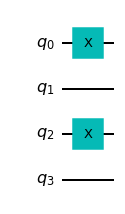

In [10]:
#create the Neel state |1010> 
Neel_state_circuit = qk.QuantumCircuit(N)
Neel_state_circuit.x(0)
Neel_state_circuit.x(2)

#draw the circuit
Neel_state_circuit.draw('mpl')

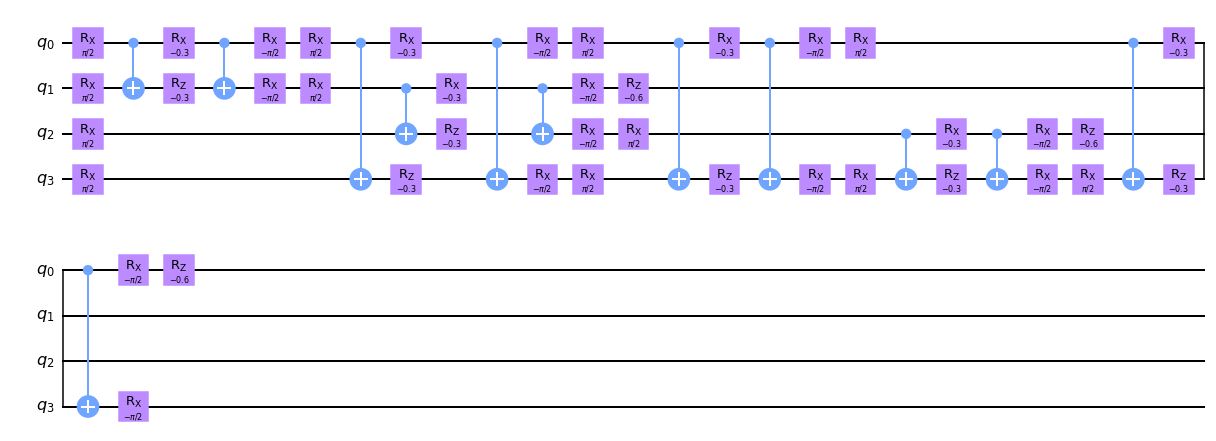

In [11]:
def evolution_circuit(num_time_steps, Jxy, h, N):
    hbar = 1   
    time_evol_circuit = qk.QuantumCircuit(N)
    #define rotation angles in term of Jxy and disorder h
    PhiX = -2.0*Jxy*del_time/hbar
    PhiZ = -2.0*Jxy*h*del_time/hbar

    for step in range(num_time_steps):
        #implement Magic Gate
        for q in range(0,N-1):
            time_evol_circuit.rx(np.pi/2,q)
            time_evol_circuit.rx(np.pi/2,q+1)
            time_evol_circuit.cx(q,q+1)
            time_evol_circuit.rx(PhiX,q)
            time_evol_circuit.rz(PhiX,q+1)
            time_evol_circuit.cx(q,q+1)
            time_evol_circuit.rx(-np.pi/2,q)
            time_evol_circuit.rx(-np.pi/2,q+1)
        #Closed_chain_part
            time_evol_circuit.rx(np.pi/2,0)
            time_evol_circuit.rx(np.pi/2,3)
            time_evol_circuit.cx(0,3)
            time_evol_circuit.rx(PhiX,0)
            time_evol_circuit.rz(PhiX,3)
            time_evol_circuit.cx(0,3)
            time_evol_circuit.rx(-np.pi/2,0)
            time_evol_circuit.rx(-np.pi/2,3)
        for q in range(0,N-1):
            time_evol_circuit.rz(PhiZ, q)

    return time_evol_circuit

#draw circuit for time-step 1
circ = evolution_circuit(1,Jxy,h,N)
circ.draw('mpl')

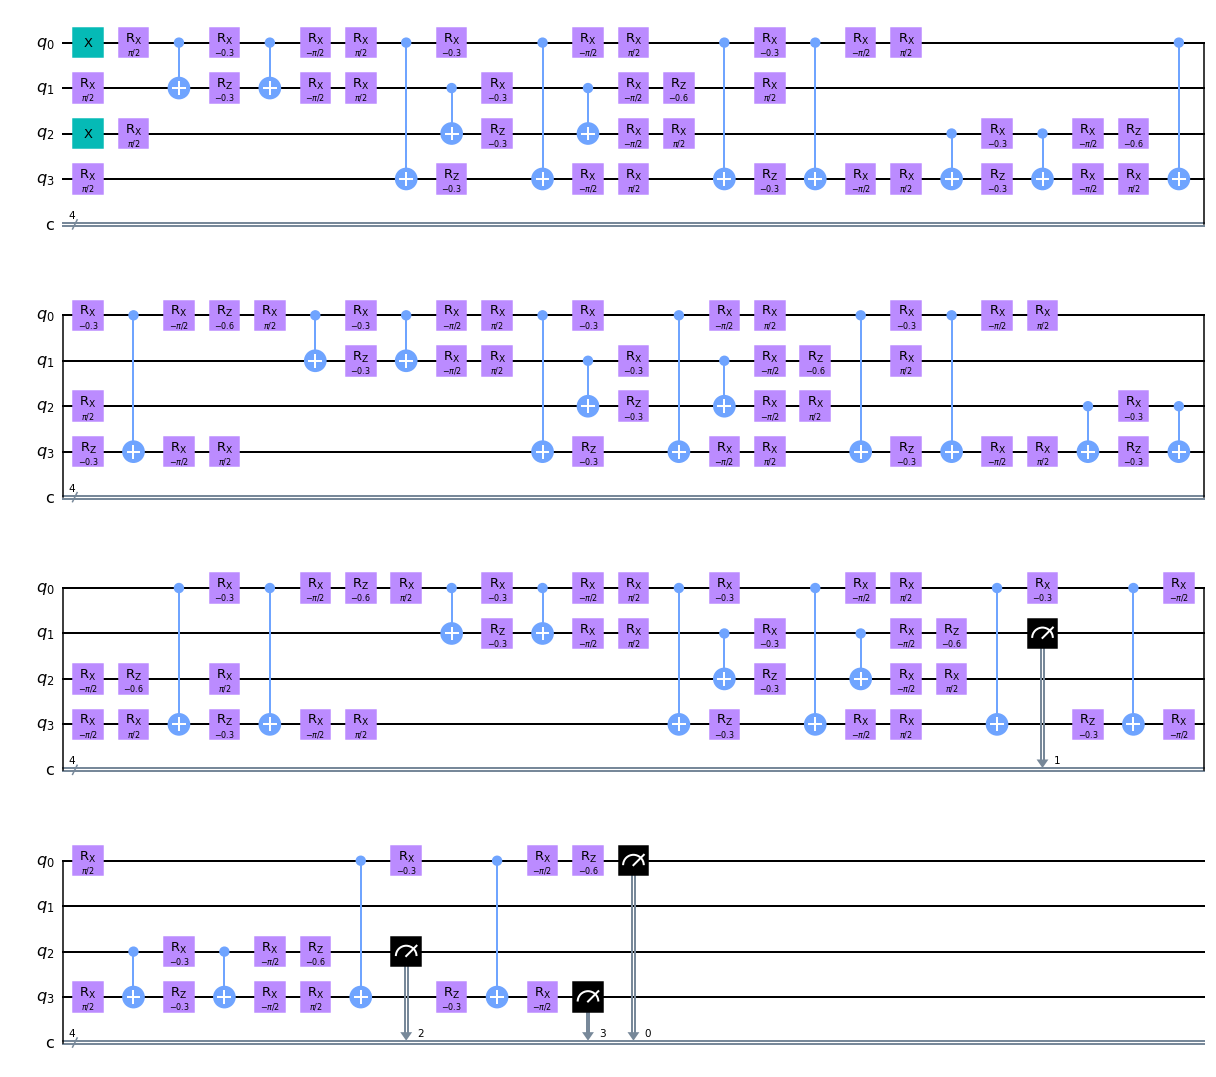

In [12]:
#Create set of final circuits for total time simulation
circuits = []
for i in range(0, num_steps+1):
    total_circ = qk.QuantumCircuit(N,N)
    total_circ.compose(Neel_state_circuit, inplace=True)
    total_circ.compose(evolution_circuit(i,Jxy,h,N), inplace=True)
    total_circ.measure(range(N),range(N))
    circuits.append(total_circ)
    
#draw the circuit for the first time-step
circuits[3].draw('mpl')

In [13]:
#Set up the simulator for simulation
simulator = Aer.get_backend('qasm_simulator')
circs_sim = qk.transpile(circuits, backend=simulator, optimization_level=3)

#Run circuits on the simulator
sim_results = execute(circs_sim, simulator, shots=shots).result()
counts = sim_results.get_counts()

In [14]:
myInt=1024
count_1100 = []
count_1010 = []
count_0110 = []
count_0011 = []
count_1001 = []
count_0101 = []
for item in counts:
    if item.get('1100') is not None:
        count_1100.append(item['1100']/myInt)
    if item.get('1010') is not None:
        count_1010.append(item['1010']/myInt)
    if item.get('0110') is not None:
        count_0110.append(item['0110']/myInt)
    if item.get('0011') is not None:
        count_0011.append(item['0011']/myInt)
    if item.get('1001') is not None:
        count_1001.append(item['1001']/myInt)
    if item.get('0101') is not None:
        count_0101.append(item['0101']/myInt)


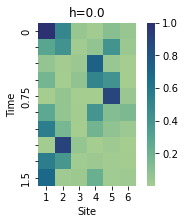

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example probability data for six sites
sites = ['1', '2', '3', '4', '5', '6']
time = list(np.arange(0.0, 1.5, 0.15))
# Reverse the time list
# time = time[::-1]

yticks= ['0', '', '', '', '0.75', '', '', '', '', '1.5']

# Find the minimum length among the lists
min_length = min(len(count_0101), len(count_0011), len(count_1100),
                 len(count_1001), len(count_1010), len(count_0110))

# Pad or truncate the lists to match the minimum length
count_0101 = count_0101[:min_length]
count_0011 = count_0011[:min_length]
count_1100 = count_1100[:min_length]
count_1001 = count_1001[:min_length]
count_1010 = count_1010[:min_length]
count_0110 = count_0110[:min_length]


# Combine the probability lists into a 2D array and transpose it
probabilities = np.array([count_0101,count_1100,count_1001, count_0011, count_1010,
                           count_0110]).T


# Set the figure size and aspect ratio
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(probabilities, xticklabels=sites, yticklabels=yticks, cmap='crest', ax=ax, square=True)

# Set axis labels and title
plt.xlabel('Site')
plt.ylabel('Time')
plt.title('h=0.0')

# Show the plot
plt.show()




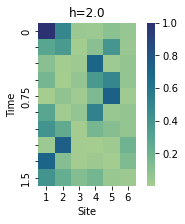

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example probability data for six sites
sites = ['1', '2', '3', '4', '5', '6']
time = list(np.arange(0.0, 1.5, 0.15))
# Reverse the time list
# time = time[::-1]

yticks= ['0', '', '', '', '0.75', '', '', '', '', '1.5']

# Find the minimum length among the lists
min_length = min(len(count_0101), len(count_0011), len(count_1100),
                 len(count_1001), len(count_1010), len(count_0110))

# Pad or truncate the lists to match the minimum length
count_0101 = count_0101[:min_length]
count_0011 = count_0011[:min_length]
count_1100 = count_1100[:min_length]
count_1001 = count_1001[:min_length]
count_1010 = count_1010[:min_length]
count_0110 = count_0110[:min_length]


# Combine the probability lists into a 2D array and transpose it
probabilities = np.array([count_0101,count_1100,count_1001, count_0011, count_1010,
                           count_0110]).T


# Set the figure size and aspect ratio
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(probabilities, xticklabels=sites, yticklabels=yticks, cmap='crest', ax=ax, square=True)

# Set axis labels and title
plt.xlabel('Site')
plt.ylabel('Time')
plt.title('h=2.0')

# Show the plot
plt.show()


